In this example, we will walk through a possible use case of the `nasapy` library by extracting the next 10 years of close-approaching objects to Earth identified by NASA's Jet Propulsion Laboratory's Small-Body Database.

Before diving in, import the packages we will use to extract and analyze the data. The data analysis library [pandas](https://pandas.pydata.org/) will be used to wrangle the data, while [seaborn](https://seaborn.pydata.org/) is used for plotting the data. The magic command [`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/plotting.html#id1) is loaded to display the generated plots.

In [1]:
import nasapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The `close_approach` method of the `nasapy` library allows one to access the JPL SBDB to extract data related to known meteoroids and asteroids within proximity to Earth. Setting the parameter `return_df=True` automatically coerces the returned JSON data into a pandas DataFrame. After extracting the data, we transform several of the variables into `float` type.

In [2]:
ca = nasapy.close_approach(date_min='2020-01-01', date_max='2029-12-31', return_df=True)

ca['dist'] = ca['dist'].astype(float)
ca['dist_min'] = ca['dist_min'].astype(float)
ca['dist_max'] = ca['dist_max'].astype(float)

The `dist` column of the returned data describes the nominal approach distance of the object in astronomical units (AU). An [astronomical unit](https://en.wikipedia.org/wiki/Astronomical_unit), or AU is roughly the distance of the Earth to the Sun, approximately 92,955,807 miles or 149,598,000 kilometers. Using the [`.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method, we can display descriptive statistics that summarize the data.

In [3]:
ca['dist'].describe()

count    729.000000
mean       0.030775
std        0.012718
min        0.000252
25%        0.021520
50%        0.031960
75%        0.041442
max        0.049983
Name: dist, dtype: float64

We see the mean approach distance in AUs is approximately 0.031, which we can transform into miles: 

In [4]:
au_miles = 92955807.26743
ca['dist'].describe()['mean'] * au_miles

2860693.219664113

Thus the average distance of the approaching objects to Earth over the next decade is about 2.86 million miles, which is more than 10 times the distance from the Earth to the Moon (238,900 miles).

What about the closest approaching object to Earth within the next ten years? Using the [`.loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method, we can find the object with the closest approaching distance.

In [5]:
ca.loc[ca['dist'] == ca['dist'].min()]

,des,orbit_id,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h
678,99942,199,2462240.407032288,2029-Apr-13 21:46,0.000252,0.000248,0.000257,7.43332261672295,5.84141384414201,< 00:01,19.7


The closest approaching known object is expected to approach Earth near the end of the decade, on April 13, 2029, at a distance of 0.00023 AU. Transforming the astronomical units into miles, we can get a better sense of the approach distance of the object.

In [6]:
print('Distance: ' + str(au_miles * ca['dist'].min()))
print('Minimum Distance: ' + str(au_miles * ca['dist_min'].min()))
print('Maximum Distance: ' + str(au_miles * ca['dist_max'].min()))

Distance: 23440.92769543333
Minimum Distance: 644.2481158331191
Maximum Distance: 23874.510393069424


Oh my! It looks like this object will approach Earth relatively close, at about 23,000 miles, in a range of [644, 23874] miles. For comparison, the maximum distance is about 1/10 of the distance from the Earth to the Moon.

Let's get a sense of the number of approaching objects to Earth by year over the next decade. First, we extract the year of the approach date using a combination of [`.apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html) and [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) into a new column `approach_year`.

In [7]:
ca['approach_year'] = ca['cd'].apply(lambda x: pd.to_datetime(x).year)

Using the [`.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method, we create a new DataFrame with the aggregated count of approaching objects for each year.

In [8]:
approaches_by_year = ca.groupby('approach_year').count().reset_index()

We can use seaborn's [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) function to plot the count of approaching objects for each year.

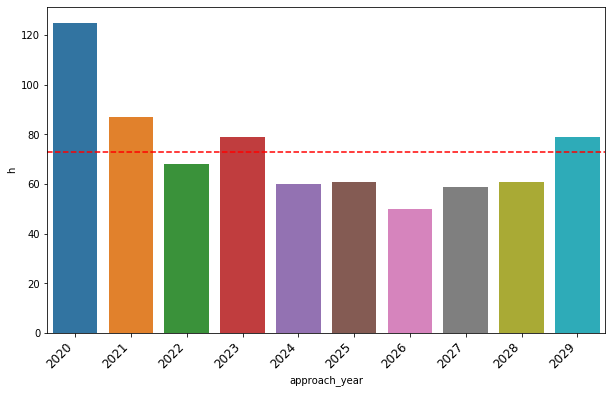

In [9]:
plt.figure(figsize=(10, 6))
p = sns.barplot(x='approach_year', y='h', data=approaches_by_year)
plt.axhline(approaches_by_year['h'].mean(), color='r', linestyle='--')
p = p.set_xticklabels(approaches_by_year['approach_year'], rotation=45, ha='right', fontsize=12)

Interestingly, this year (2020) will have the most activity, and then it will somewhat decline over the next few years until the end of the decade. On average, there are a little less than 80 Earth approaching objects each year of the decade.

As the last example, let's plot the distribution of the approaching object distances using seaborn's [`.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) which creates a kernel destiny plot. We can also add a mean line of the distances similar to how we did above.

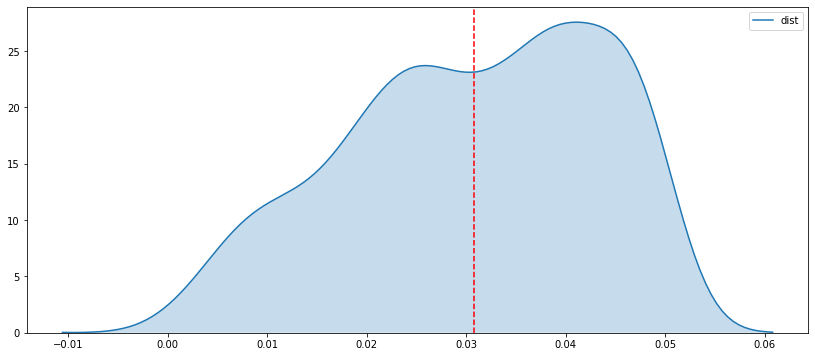

In [10]:
plt.figure(figsize=(14, 6))
plt.axvline(ca['dist'].astype(float).mean(), color='r', linestyle='--')
sns.kdeplot(ca['dist'], shade=True)

As we noted above, the mean approach distance is a little more than 0.03, which we can see in the density plot above. Lastly, we can plot a normal distribution over the distribution of the distances using [numpy.random.normal](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) to get a quick comparison of the actual distribution compared to a normal one.

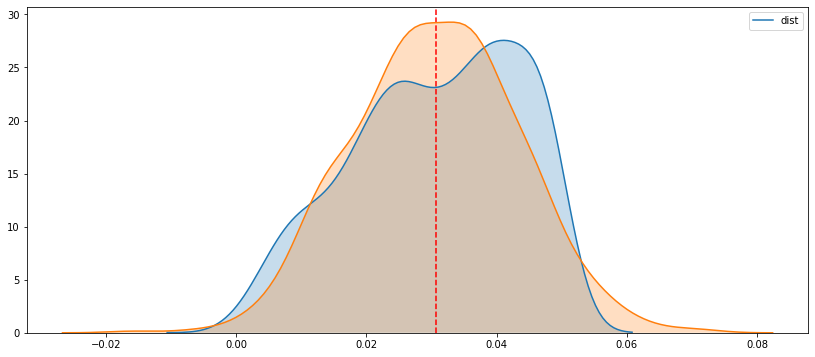

In [11]:
plt.figure(figsize=(14, 6))

x = np.random.normal(size=len(ca['dist']), 
                     scale=ca['dist'].std(), 
                     loc=ca['dist'].mean())

plt.axvline(ca['dist'].mean(), color='r', linestyle='--')

sns.kdeplot(ca['dist'], shade=True)
sns.kdeplot(x, shade=True)

We see the distribution of the distances is not quite normal. There are definitely much more sophisticated techniques for analyzing the distribution of a dataset, but that will be saved for a possible future exercise.